# Geolocation of Attacker IP Addresses

Using log data from a Cowrie honeypot stored in an SQLite database, we can plot the attackers on a map. 

In [11]:
import common
import pandas as pd
import folium

conn = common.connect_db('db.sqlite')
data = pd.read_sql_query("SELECT * from attack_log", conn)

m = folium.Map(location=[50, -25], zoom_start=3)

for index, element in data.iterrows():
    lat = element['latitude']
    lon = element['longitude']
    country_name = element['country_name']
    subdivision_name = element['subdivision_name']
    city_name = element['city_name']
    radius = element['accuracy_radius']
    attack_count = element['attack_count']

    
    if element['asn'] is not None:
        asn = element['asn']
    else:
        asn = "No ASN"
    src_ip = element['src_ip']

    folium.Marker([lat, lon], popup='<i>'+city_name+', '+subdivision_name+', '+ '</i><b>'+ \
                  country_name+'<br><br></b>Accuracy: '+str(radius)+'km <br>' + 'Attacks: ' + str(attack_count) +'<br><br>'+asn + '<b><br>' + \
                  src_ip + '</b></i>').add_to(m)
m

## Attacks by Country

Here is some markdown, blah blah blah

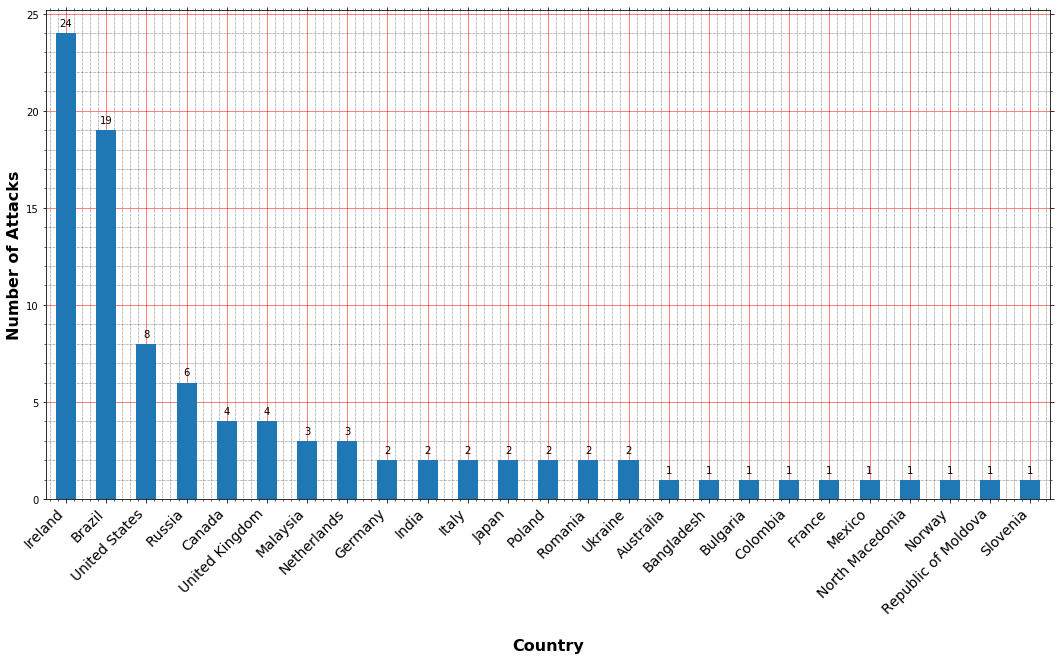

In [9]:
#@hidden_cell

# Group data by country
country = df.groupby(['country_name']).size().to_frame('attack_count').reset_index().sort_values(by=['attack_count','country_name'], ascending=[False, True])

# Use the rank function to sort countries by the number of attacks
country['Rank'] = country['attack_count'].rank(method='dense', ascending=False).astype(int)

fig, ax = plt.subplots()
country[0:25].plot('country_name','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)

ax.set_xlabel('\nCountry', fontweight="bold", size=16)
ax.set_ylabel('Number of Attacks', fontweight="bold", size=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks


## Attacks by City of Origin

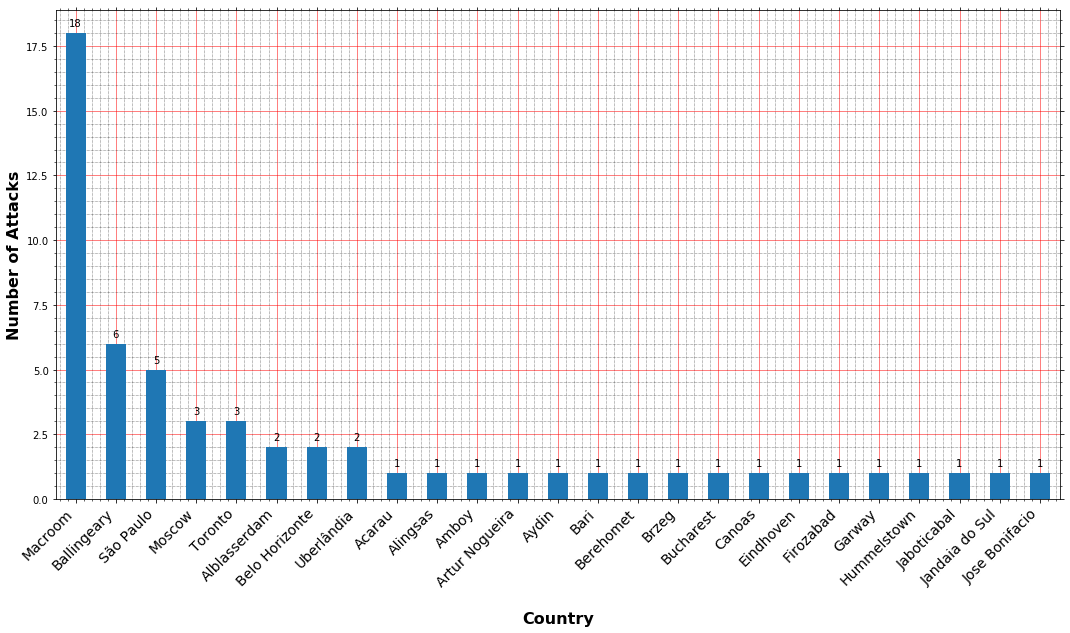

In [3]:
# Group data by country
country = df.groupby(['city_name']).size().to_frame('attack_count').reset_index().sort_values(by=['attack_count','city_name'], ascending=[False, True])

# Use the rank function to sort countries by the number of attacks
country['Rank'] = country['attack_count'].rank(method='dense', ascending=False).astype(int)

fig, ax = plt.subplots()
country[0:25].plot('city_name','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)


ax.set_xlabel('\nCountry', fontweight="bold", size=16)
ax.set_ylabel('Number of Attacks', fontweight="bold", size=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks


## IP Addresses by Attacks

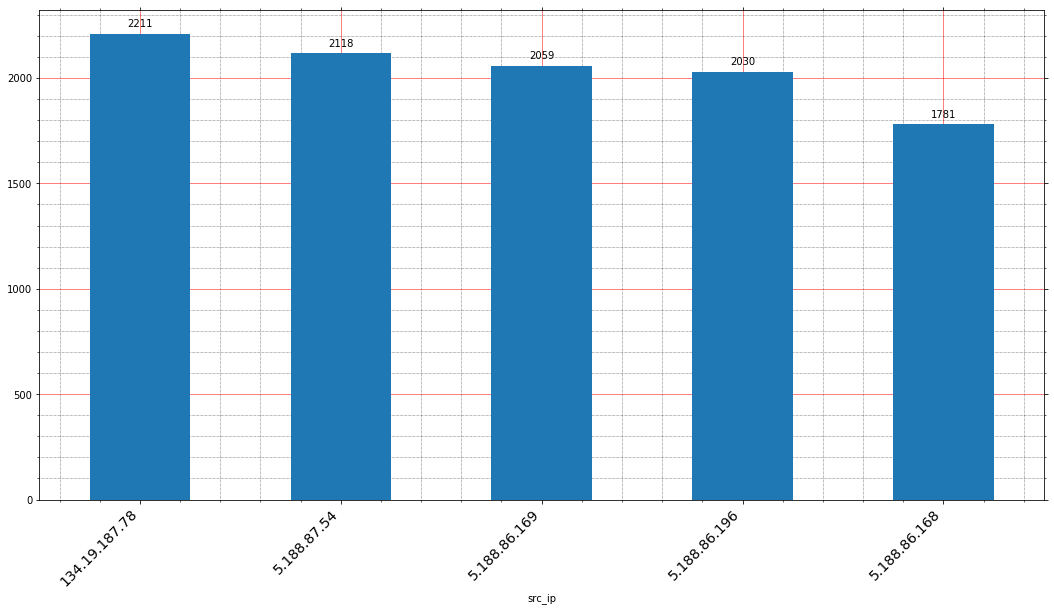

In [62]:
# Group data by country

data = pd.read_sql_query("SELECT * from attack_log", conn)

# Filter data
data = data[['src_ip','attack_count']]
data = data.where((pd.notnull(data)),None)
data = data[~data['attack_count'].isin(['NaN','nan',None,'0',''])]

# This fixes a strange glitch where attack_count was shown as float
data["attack_count"] = pd.to_numeric(data["attack_count"], downcast='integer')

data = data.sort_values(['attack_count'],ascending=False)

fig, ax = plt.subplots()

data[0:5].plot('src_ip','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks

In [92]:
# Broken heatmap




with open("data/world-countries.json") as f:
    geo_json = f.read()

    data = pd.read_sql_query("SELECT * from attack_log", conn)
    data = data[['country_name','attack_count']]
    data['country_name'] = data['country_name'].astype(str)
    
    # This fixes a strange glitch where attack_count was shown as float
    data["attack_count"] = pd.to_numeric(data["attack_count"], downcast='integer')
    print(data)
    m = folium.Map(location=[48, -102], zoom_start=3)

    folium.Choropleth(
        geo_data=geo_json,
        name='choropleth',
        data=data,
        columns=['country_name', 'attack_count'],
        key_on='feature.properties.name',
        fill_color='OrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Attack Rate'
    ).add_to(m)

    #folium.LayerControl().add_to(m)
    
m

           country_name  attack_count
0                Canada           NaN
1                Canada           NaN
2                Brazil           NaN
3   Republic of Moldova           NaN
4               Germany           NaN
5                Brazil           NaN
6               Romania          12.0
7               Ireland        1483.0
8               Ireland        1528.0
9               Ireland        2118.0
10              Ireland        1781.0
11              Ireland        1567.0
12              Ireland        1214.0
13              Ireland         137.0
14              Ireland        1709.0
15              Ireland        1581.0
16              Ireland        1592.0
17              Ireland        2030.0
18              Ireland        1657.0
19              Ireland        1324.0
20              Ireland        1130.0
21              Ireland        1570.0
22              Ireland        1330.0
23          Netherlands        2211.0
24              Ireland        2059.0
25          